## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.preprocessing as skpre
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

import VAE

## Choose Variables and Preprocess

In [2]:
# Load in the persons PUMS dataset for WA state
p_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_p53.csv")
h_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_h53.csv")

# Filter to desired variables (numeric then categorical)
# pums_data_h = h_df[['SERIALNO','HINCP','NP','VEH']]
# pums_data_p = p_df[['SERIALNO','AGEP','SEX','SCHL','COW']]
pums_data_h = h_df[['SERIALNO','HINCP','NP','VEH','BLD','ACCESS']]
pums_data_p = p_df[['SERIALNO','AGEP','JWMNP','SEX','SCHL','COW','DPHY','DEYE','DREM','DOUT','ESR','RAC1P']]
del h_df
del p_df
pums_data = pd.merge(pums_data_p, pums_data_h, on='SERIALNO')
pums_data = pums_data.drop(labels=['SERIALNO'], axis=1)

# Sort by cont/cat, then by pers/hh
# pums_data = pums_data[['AGEP','HINCP','SCHL','COW','SEX','NP','VEH']]
pums_data = pums_data[['AGEP','HINCP','JWMNP','SCHL','COW','SEX','DPHY','DEYE','DREM','DOUT','ESR','RAC1P','NP','VEH','BLD','ACCESS']]

# Remove NA values and check n before/after
print(f"Dataset n={len(pums_data)} pre-cleaning")
pums_data = pums_data.dropna()
print(f"Dataset n={len(pums_data)} post-cleaning")
pums_data

Dataset n=359075 pre-cleaning
Dataset n=150203 post-cleaning


,AGEP,HINCP,JWMNP,SCHL,COW,SEX,DPHY,DEYE,DREM,DOUT,ESR,RAC1P,NP,VEH,BLD,ACCESS
4,52,210500.0,70.0,21.0,1.0,1,2.0,2,2.0,2.0,1.0,1,3,3.0,2.0,1.0
5,51,210500.0,20.0,21.0,3.0,2,2.0,2,2.0,2.0,1.0,1,3,3.0,2.0,1.0
7,59,50310.0,30.0,19.0,3.0,1,2.0,2,2.0,2.0,1.0,1,2,3.0,1.0,3.0
8,56,50310.0,15.0,16.0,1.0,2,2.0,2,2.0,2.0,1.0,1,2,3.0,1.0,3.0
9,40,31200.0,5.0,5.0,1.0,1,2.0,2,2.0,2.0,1.0,9,5,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356007,37,55000.0,50.0,21.0,1.0,1,2.0,2,2.0,2.0,1.0,6,3,2.0,2.0,1.0
356010,33,102000.0,65.0,18.0,1.0,1,2.0,2,2.0,2.0,1.0,1,4,2.0,3.0,1.0
356013,48,106400.0,60.0,18.0,1.0,1,2.0,2,2.0,2.0,1.0,1,3,4.0,2.0,1.0
356014,49,106400.0,30.0,19.0,1.0,2,2.0,2,2.0,2.0,1.0,1,3,4.0,2.0,1.0


In [3]:
CAT_IDX = 3  # Index of first categorical var in all variables
HH_IDX = [1,12,13,14,15]  # Indices of household variables
LEN_PERS = pums_data_p.shape[1] - 1  # Number of person variables before OHE
LEN_HH = pums_data_h.shape[1] - 1  # Number of household variables before OHE
VAR_DIM = pums_data.shape[1]  # Length of all variables before OHE
VAR_NAMES = pums_data.columns  # Names of all variables before OHE
HH_VAR_NAMES = pums_data_h.columns  # Names of the hh variables

del pums_data_p
del pums_data_h

# Split categorical data into OHE vars, save num classes per variable
dummies_list = []
for x in range(CAT_IDX, VAR_DIM):
    dummies = pums_data.iloc[:,x]
    dummies = pd.get_dummies(dummies, prefix=f"{pums_data.columns[x]}_")
    dummies_list.append(dummies)
    del dummies
CAT_LENGTHS = [x.shape[1] for x in dummies_list]
print(f"Categorical variable class lengths: {CAT_LENGTHS}")

Categorical variable class lengths: [24, 8, 2, 2, 2, 2, 2, 2, 9, 18, 7, 10, 3]


In [4]:
# Final data frame after encoding OHE
model_data_df = pums_data.iloc[:,:CAT_IDX]
for ohe_var in dummies_list:
    model_data_df = pd.concat([model_data_df, ohe_var], axis=1)
del ohe_var
MANIFEST_DIM = model_data_df.shape[1]

# Add columns for original household variables; these will be fed to decoder but not encoder
model_data_df = pd.concat([model_data_df, pums_data.iloc[:,HH_IDX]], axis=1)

# Preview data that will be fed into model
model_data_df

,AGEP,HINCP,JWMNP,SCHL__1.0,SCHL__2.0,SCHL__3.0,SCHL__4.0,SCHL__5.0,SCHL__6.0,SCHL__7.0,...,BLD__9.0,BLD__10.0,ACCESS__1.0,ACCESS__2.0,ACCESS__3.0,HINCP,NP,VEH,BLD,ACCESS
4,52,210500.0,70.0,0,0,0,0,0,0,0,...,0,0,1,0,0,210500.0,3,3.0,2.0,1.0
5,51,210500.0,20.0,0,0,0,0,0,0,0,...,0,0,1,0,0,210500.0,3,3.0,2.0,1.0
7,59,50310.0,30.0,0,0,0,0,0,0,0,...,0,0,0,0,1,50310.0,2,3.0,1.0,3.0
8,56,50310.0,15.0,0,0,0,0,0,0,0,...,0,0,0,0,1,50310.0,2,3.0,1.0,3.0
9,40,31200.0,5.0,0,0,0,0,1,0,0,...,0,0,1,0,0,31200.0,5,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356007,37,55000.0,50.0,0,0,0,0,0,0,0,...,0,0,1,0,0,55000.0,3,2.0,2.0,1.0
356010,33,102000.0,65.0,0,0,0,0,0,0,0,...,0,0,1,0,0,102000.0,4,2.0,3.0,1.0
356013,48,106400.0,60.0,0,0,0,0,0,0,0,...,0,0,1,0,0,106400.0,3,4.0,2.0,1.0
356014,49,106400.0,30.0,0,0,0,0,0,0,0,...,0,0,1,0,0,106400.0,3,4.0,2.0,1.0


In [5]:
# Separate into train/test data
train_idx = round(len(model_data_df)*.98)
train_data = model_data_df.iloc[0:train_idx,:]
test_data = model_data_df.iloc[train_idx:len(model_data_df),:]

In [6]:
# Standardize the input data from 0 to 1 for numerical variables
scaler_pers_train = skpre.MinMaxScaler()
scaler_hh_train = skpre.MinMaxScaler()
train_data = train_data.values
train_data[:,:CAT_IDX] = scaler_pers_train.fit_transform(train_data[:,:CAT_IDX])
train_data[:,MANIFEST_DIM:] = scaler_hh_train.fit_transform(train_data[:,MANIFEST_DIM:])

scaler_pers_test = skpre.MinMaxScaler()
scaler_hh_test = skpre.MinMaxScaler()
test_data = test_data.values
test_data[:,:CAT_IDX] = scaler_pers_test.fit_transform(test_data[:,:CAT_IDX])
test_data[:,MANIFEST_DIM:] = scaler_hh_test.fit_transform(test_data[:,MANIFEST_DIM:])

## Set Parameters and Define Model

In [7]:
# Hyperparameters
BATCH_SIZE = 512
EPOCHS = 100
LATENT_DIM = 6
HIDDEN_DIM = 32
KL_WEIGHT = .05
NUM_WEIGHT = 2

## Training

Epoch 1/100
288/288 [==============================] - 2s 6ms/step - tot_loss: 250.6192 - rec_loss: 250.2264 - kl_loss: 0.3928
Epoch 2/100
288/288 [==============================] - 2s 6ms/step - tot_loss: 36.4674 - rec_loss: 35.8506 - kl_loss: 0.6168
Epoch 3/100
288/288 [==============================] - 2s 6ms/step - tot_loss: 14.9422 - rec_loss: 14.1535 - kl_loss: 0.7887
Epoch 4/100
288/288 [==============================] - 2s 6ms/step - tot_loss: 13.0005 - rec_loss: 12.1258 - kl_loss: 0.8748
Epoch 5/100
288/288 [==============================] - 2s 6ms/step - tot_loss: 12.0730 - rec_loss: 11.1429 - kl_loss: 0.9301
Epoch 6/100
288/288 [==============================] - 2s 6ms/step - tot_loss: 11.4966 - rec_loss: 10.5319 - kl_loss: 0.9648
Epoch 7/100
288/288 [==============================] - 2s 5ms/step - tot_loss: 11.0286 - rec_loss: 10.0417 - kl_loss: 0.9869
Epoch 8/100
288/288 [==============================] - 2s 6ms/step - tot_loss: 10.6126 - rec_loss: 9.6128 - kl_loss: 0.9997

Epoch 67/100
288/288 [==============================] - 2s 5ms/step - tot_loss: 2.6729 - rec_loss: 1.7076 - kl_loss: 0.9653
Epoch 68/100
288/288 [==============================] - 2s 6ms/step - tot_loss: 2.6500 - rec_loss: 1.6859 - kl_loss: 0.9641
Epoch 69/100
288/288 [==============================] - 2s 5ms/step - tot_loss: 2.6453 - rec_loss: 1.6826 - kl_loss: 0.9627
Epoch 70/100
288/288 [==============================] - 2s 5ms/step - tot_loss: 2.6136 - rec_loss: 1.6535 - kl_loss: 0.9601
Epoch 71/100
288/288 [==============================] - 2s 5ms/step - tot_loss: 2.5861 - rec_loss: 1.6271 - kl_loss: 0.9590
Epoch 72/100
288/288 [==============================] - 2s 6ms/step - tot_loss: 2.5604 - rec_loss: 1.6036 - kl_loss: 0.9568
Epoch 73/100
288/288 [==============================] - 2s 5ms/step - tot_loss: 2.5498 - rec_loss: 1.5947 - kl_loss: 0.9551
Epoch 74/100
288/288 [==============================] - 2s 5ms/step - tot_loss: 2.5248 - rec_loss: 1.5715 - kl_loss: 0.9533
Epoch 75

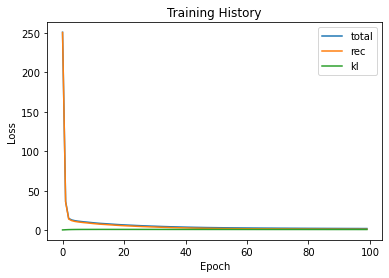

In [8]:
start_time = time.time()

# Train
vae = VAE.VAE(MANIFEST_DIM, HIDDEN_DIM, LATENT_DIM, CAT_LENGTHS, CAT_IDX, LEN_HH, KL_WEIGHT, NUM_WEIGHT)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE)

print(f"--- {time.time() - start_time} seconds ---")

# Plot model loss/training progress
plt.plot(history.history['tot_loss'])
plt.plot(history.history['rec_loss'])
plt.plot(history.history['kl_loss'])
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["total","rec","kl"], loc="upper right")
plt.show()

## Testing

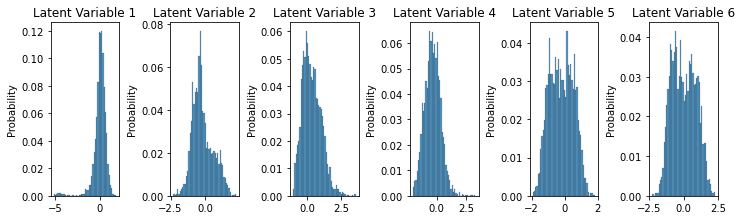

In [9]:
# Get latent vars from the encoder; feed to decoder and get sampled manifest variables
z_mean, z_logvar, z = vae.encoder.predict(test_data[:,:MANIFEST_DIM])

# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=1, ncols=LATENT_DIM, figsize=(10,3))
fig.tight_layout(w_pad=2, h_pad=10)

for i in range(LATENT_DIM):
    sns.histplot(z[:,i], ax=axes[i], bins=50, stat="probability")
    axes[i].set_title(f"Latent Variable {i+1}")

In [10]:
# Draw predictions from test data
results = vae.predict(test_data)
loss_num, loss_cat = VAE.get_reconstruction_loss(test_data, results, CAT_IDX, CAT_LENGTHS)
print(f"Numerical Variable Loss: {loss_num}")
print(f"Categorical Variable Loss: {loss_cat}")

Numerical Variable Loss: 12.701640129089355
Categorical Variable Loss: 13.730029106140137


In [11]:
# Transform continuous/categorical variables back to real values in the results and test data
if len(CAT_LENGTHS) > 0:  
    # Handle case where are categorical variables
    results_num = scaler_pers_train.inverse_transform(results[0])
    test_data_num = scaler_pers_test.inverse_transform(test_data[:,:CAT_IDX])
    results_df = pd.DataFrame(results_num)
    test_data_df = pd.DataFrame(test_data_num)

    # Argmax for each categorical variable the results data
    for i, x in enumerate(results[1]):
        result = np.argmax(x, axis=1) + 1
        results_df[f"{x}"] = result

    # Argmax for each categorical variable the test data
    current = CAT_IDX
    for i, x in enumerate(CAT_LENGTHS):
        test_data_cat = test_data[:,current:(current + x)]
        test_data_cat = np.argmax(test_data_cat, axis=1) + 1
        test_data_df[f"{i}"] = test_data_cat
        current += x

else:
    # Handle case where there are no categorical variables
    results_num = scaler_pers_train.inverse_transform(results)
    test_data_num = scaler_pers_test.inverse_transform(test_data[:,:CAT_IDX])
    results_df = pd.DataFrame(results_num)
    test_data_df = pd.DataFrame(test_data_num)

# Add back original variables names to the results
results_df.columns = VAR_NAMES
test_data_df.columns = VAR_NAMES

<ipython-input-12-2dc3b3d4b2af>:3: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout(h_pad=10)


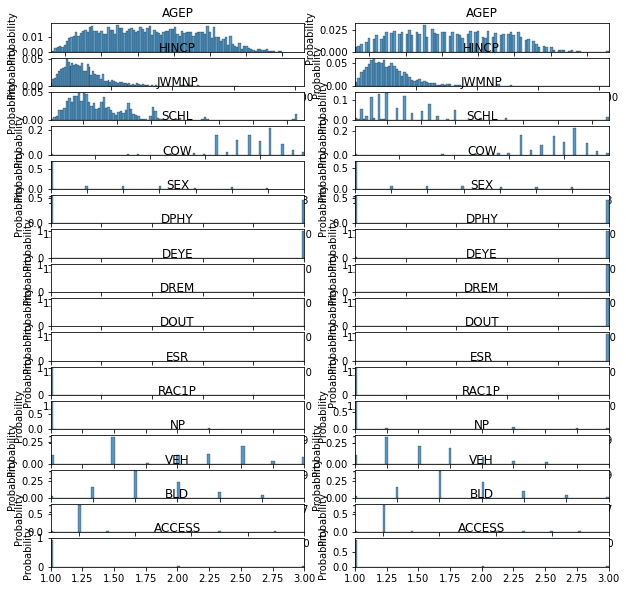

In [12]:
# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=2, figsize=(10,10))
fig.tight_layout(h_pad=10)

for i, col in enumerate(VAR_NAMES):
    sns.histplot(results_df[col], ax=axes[i,0], stat='probability', bins=100).set(xlim=(min(test_data_df[col]),max(test_data_df[col])))
    axes[i,0].set_title(col)
    axes[i,0].set_xlabel(None)
    sns.histplot(test_data_df[col], ax=axes[i,1], stat='probability', bins=100).set(xlim=(min(test_data_df[col]),max(test_data_df[col])))
    axes[i,1].set_title(col)
    axes[i,1].set_xlabel(None)

## Generating Synthetic Population

In [13]:
# Load in the synthetic households
synth_hh_df = pd.read_csv('data/synthetic_populations/wa_households.csv')

# How many variables represent each household
HH_DIM = 5

# Create new column for copy of hh sizes and scale household input variables
sizes = synth_hh_df[['NP']]
synth_hh_df = pd.concat([synth_hh_df, sizes], axis=1)
synth_hh_df.columns = ['HINCP','NP','VEH','SIZE','BLD','ACCESS']

# Multiply the inputs by the number of persons per household (hh of size 3 becomes 3 rows with same scaled hh inputs)
synth_hh_df['HH_ID'] = synth_hh_df.index
synth_hh_df = synth_hh_df.reindex(synth_hh_df.index.repeat(synth_hh_df['SIZE']))
synth_hh_df_unscaled = synth_hh_df.copy()

# Scale the hh variables
synth_hh_df.iloc[:,:HH_DIM] = scaler_hh_train.fit_transform(synth_hh_df.iloc[:,:HH_DIM])
synth_hh_values = synth_hh_df.iloc[:,:HH_DIM]

del synth_hh_df

# How many synthetic households to fill
POP_SIZE = len(synth_hh_values)

In [14]:
# Generate random normal sample to represent each latent variable, for each row (different person per row)
epsilon = np.random.normal(loc=0, scale=1, size=(POP_SIZE, LATENT_DIM))

In [15]:
start_time = time.time()

# Generate persons; each person has unique latent input, plus shared hh inputs with their household
results = vae.decoder.predict([epsilon[0:100000], synth_hh_values[0:100000]])

print(f"--- {time.time() - start_time} seconds ---")

--- 4.224393367767334 seconds ---


In [16]:
# Transform continuous/categorical variables back to real values in the results and test data
if len(CAT_LENGTHS) > 0:  
    # Handle case where are categorical variables
    results_num = scaler_pers_train.inverse_transform(results[0])
    test_data_num = scaler_pers_test.inverse_transform(test_data[:,:CAT_IDX])
    results_df = pd.DataFrame(results_num)
    test_data_df = pd.DataFrame(test_data_num)

    # Argmax for each categorical variable the results data
    for i, x in enumerate(results[1]):
        result = np.argmax(x, axis=1) + 1
        results_df[f"{i}"] = result
    current = CAT_IDX

    # Argmax for each categorical variable the test data
    for i, x in enumerate(CAT_LENGTHS):
        test_data_cat = test_data[:,current:(current + x)]
        test_data_cat = np.argmax(test_data_cat, axis=1) + 1
        test_data_df[f"{i}"] = test_data_cat
        current += x
else:
    # Handle case where there are no categorical variables
    results_num = scaler_pers_train.inverse_transform(results)
    test_data_num = scaler_pers_test.inverse_transform(test_data[:,:CAT_IDX])
    results_df = pd.DataFrame(results_num)
    test_data_df = pd.DataFrame(test_data_num)

# Add back original variables names to the results
results_df.columns = VAR_NAMES
test_data_df.columns = VAR_NAMES

# Add back household ids to the results
results_df['HH_ID'] = synth_hh_df_unscaled['HH_ID'].values[0:100000]

# In the PUMS data, VEH is indexed from 0 (sensibly). However we have just added 1 to all cat vars, so remove it
results_df['VEH'] = results_df['VEH'] - 1

In [17]:
# Assign the control variables from the synthetic households to individuals (replace what came from the model)
for var in HH_VAR_NAMES[1:]:
    results_df[f"{var}"] = synth_hh_df_unscaled[f"{var}"].values[0:100000]

In [18]:
# Save the synthesized persons
results_df.to_csv('data/synthetic_populations/wa_persons.csv', index=False)
results_df

,AGEP,HINCP,JWMNP,SCHL,COW,SEX,DPHY,DEYE,DREM,DOUT,ESR,RAC1P,NP,VEH,BLD,ACCESS,HH_ID
0,18.489706,-2661.0698,63.323200,23,1,1,2,2,2,1,1,6,4,2,1,4,0
1,58.023129,-2661.0698,47.144447,18,1,1,2,2,2,2,1,1,4,2,1,4,0
2,23.655602,23914.1640,122.980042,1,1,1,2,2,2,2,1,2,5,3,1,5,1
3,52.922321,15968.2860,83.609787,21,4,2,2,2,2,2,1,1,2,2,1,2,2
4,17.244753,15968.2860,8.982693,1,1,2,2,2,2,2,1,6,2,2,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,3.716313,70210.5500,87.502266,23,5,1,2,2,2,2,1,6,1,1,1,1,41623
99996,53.901928,13707.6980,9.810497,19,1,1,2,2,2,2,1,6,2,2,1,2,41624
99997,41.982174,13707.6980,105.342064,21,1,1,2,2,2,2,1,1,2,2,1,2,41624
99998,-2.647694,1314.7853,30.679411,21,1,2,2,2,2,2,1,6,3,2,1,3,41625


<ipython-input-19-43e56f2f1974>:3: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout(h_pad=20)


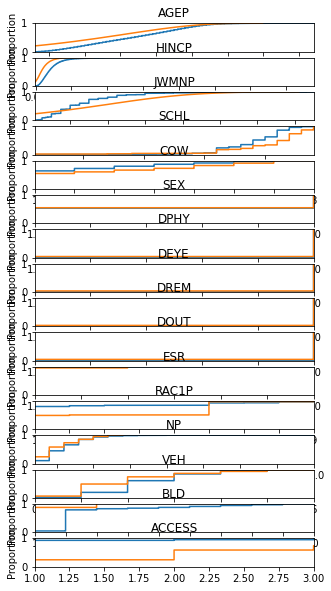

In [19]:
# Generate Distributions of All HH variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=1, figsize=(5,10))
fig.tight_layout(h_pad=20)

for i, var in enumerate(VAR_NAMES):
    sns.ecdfplot(data=pums_data, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    sns.ecdfplot(data=results_df, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    axes[i].set_title(var)
    axes[i].set_xlabel(None)

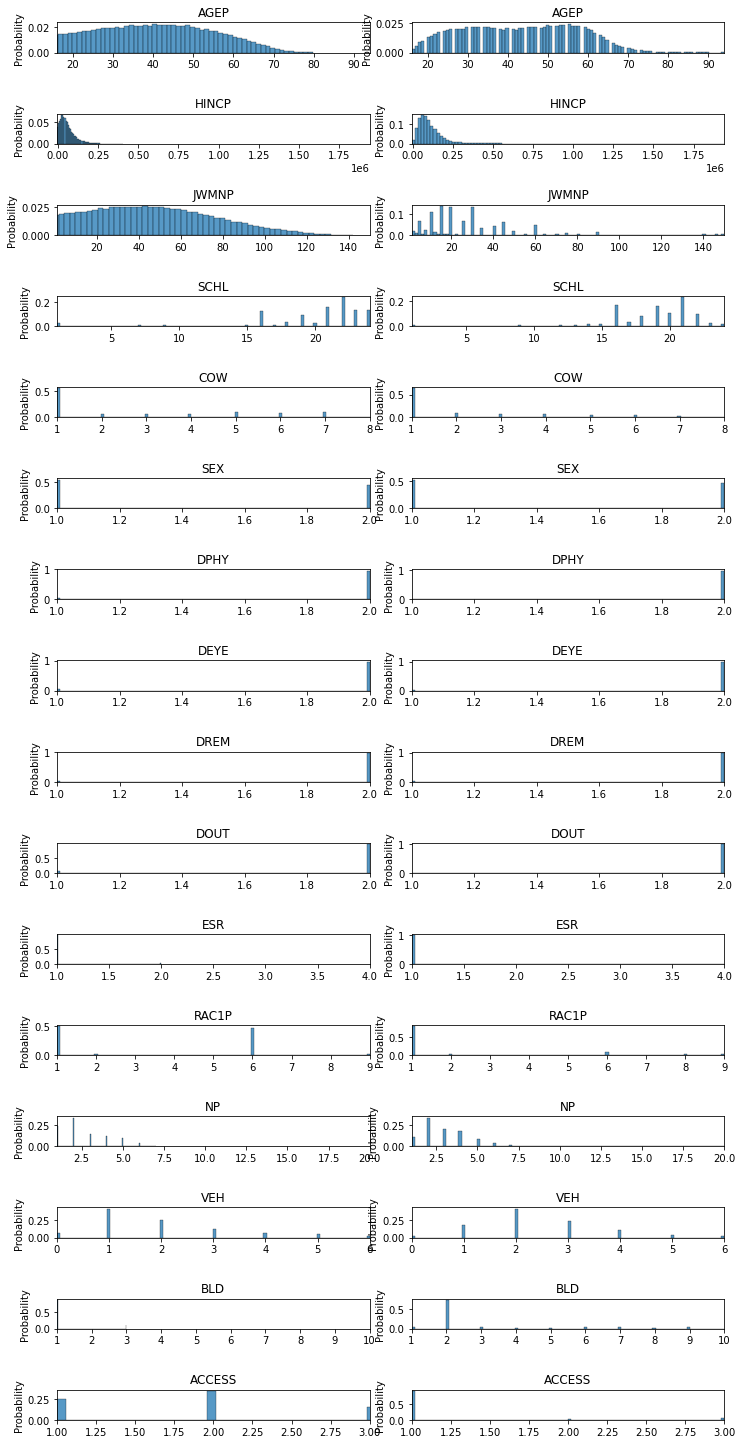

In [20]:
# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=2, figsize=(10,20))
fig.tight_layout(h_pad=4)

for i, col in enumerate(VAR_NAMES):
    sns.histplot(results_df[col], ax=axes[i,0], stat='probability', bins=100).set(xlim=(min(pums_data[col]),max(pums_data[col])))
    axes[i,0].set_title(col)
    axes[i,0].set_xlabel(None)
    sns.histplot(pums_data[col], ax=axes[i,1], stat='probability', bins=100).set(xlim=(min(pums_data[col]),max(pums_data[col])))
    axes[i,1].set_title(col)
    axes[i,1].set_xlabel(None)